In [1]:
import h5py, numpy, pylab
from pycbc.waveform.spa_tmplt import spa_length_in_time
from pycbc.sensitivity import volume_to_distance_with_errors, volume_montecarlo
from scipy.interpolate import interp1d

################# Set up interpolators for ideal sensitivity #############################

def abrev(abv):
    ifos = []
    for k in abv:
        ifos.append(k.upper() + '1')
    return ifos

injfiles = {'design':'design_inj.hdf',
            'aplus':'aplus_inj.hdf',
            'voyager':'voyager_inj.hdf'}
snrfiles = {'design':'design_snr.hdf',
            'aplus':'aplus_snr.hdf',
            'voyager':'voyager_snr.hdf'}

combos = {'design':['hlv', 'hlvk'], 'aplus':['hlv', 'hlvki'], 'voyager':['hlv', 'hlvki']}

volume = {era: {abv: {} for abv in combos[era]} for era in combos}

for era in combos:
    ifile = h5py.File(injfiles[era], 'r')
    dist = ifile['distance'][:]

    sfile = h5py.File(snrfiles[era], 'r')
    freqs = sfile['freqs'][:]
    times = -1.0 * spa_length_in_time(mass1=1.4, mass2=1.4, f_lower=freqs, phase_order=-1)

    for abv in combos[era]:
        ifos = abrev(abv)
        
        nsnr = 0
        for ifo in ifos:
            nsnr += sfile[ifo][:]**2.0
        nsnr = nsnr ** 0.5
        
        vs = []
        for i in range(nsnr.shape[1]):
            found = nsnr[:,i] > 10.0
            missed = ~found
            
            mchirp = numpy.ones(len(dist)) + 1.4
            
            # Calculate the sensitive volume using monte-carlo integration
            v, e = volume_montecarlo(dist[found], dist[missed], mchirp[found], mchirp[missed],
                                    'distance', 'uniform', 'distance')
            vs.append(v)
        
        volume[era][abv] = interp1d(times, vs, 'cubic', fill_value=0, bounds_error=False)

In [29]:
################### Set up the search measured volumes ########################
fnames = ['design_hlv.hdf',
          'design_hlvk.hdf',
          'aplus_hlv.hdf',
          'aplus_hlvki.hdf',
          'voyager_hlv.hdf',
          'voyager_hlvki.hdf',
         ]


search = {era: {abv: {} for abv in combos[era]} for era in combos}

for fname in fnames:
    era = fname.split('_')[0]
    abv = fname.split('_')[1].split('.')[0]
    
    f= h5py.File(fname, 'r')
    ifar = f['ifar'][:]


    ds = []
    el = []
    eh = []

    fstops = f['f_finals'][:]
    time = -1.0 * spa_length_in_time(mass1=1.4, mass2=1.4, f_lower=fstops, phase_order=-1)

    for i, ff in enumerate(f['f_finals'][:]):
        ky = '%s/v' % (i)
        ke = '%s/ve' % (i)
        v = f[ky][:]
        e = f[ke][:]
        d, elv, ehv = volume_to_distance_with_errors(v, e)
        ds.append(d[8])
        el.append(elv[8])
        eh.append(ehv[8])
    ds = numpy.array(ds)
    el = numpy.array(el)    
    
    search[era][abv] = (time, ds)

In [8]:
from scipy.interpolate import PchipInterpolator

sky = {era: {abv: {} for abv in combos[era]} for era in combos}

keys = ['d90', 's01', 's50', 's10']

def loginterp(x, y):

    x = numpy.array(x)
    y = numpy.array(y)
    
    y[y<=0] = y[y>0].min()
    
    p = PchipInterpolator(x, numpy.log(y))
    return lambda t: numpy.exp(p(t))

for era in combos:
    for abv in combos[era]:
        sfile = h5py.File('sky_{}_{}.hdf'.format(era, abv), 'r')

        freqs = numpy.array([float(k) for k in sfile.keys()])
        times = -1.0 * spa_length_in_time(mass1=1.4, mass2=1.4, f_lower=freqs, phase_order=-1)        
        
        ifile = h5py.File(injfiles[era], 'r')
        itime = ifile['tc'][:]
        idist = ifile['distance'][:]
        
        fdet = sky[era][abv]
        
        for k in keys:
            fdet[k] = []
        
        for k in sfile:
            stimes = sfile[k]['times'][:]
            l = numpy.searchsorted(itime, stimes-2.0)
            r = numpy.searchsorted(itime, stimes+2.0)
            assert ((r-l) == 1).sum() == len(stimes)
            kid = l

            w = idist[kid] ** 2.0 # re-weight to volume instead of uniform in distance
            w /= w.sum()

            
            #### Detectability fractions ########
            for cred in ['a10', 'a25', 'a50', 'a90']:
                for size in [1000, 100, 10, 1]:
                    key = "{}{}".format(size, cred)
                    if key not in fdet:
                        fdet[key] = []
                              
                    b = (sfile[k][cred][:] < size)
                    num = w[b].sum()
                    fdet[key].append(num)


            #### Distance to source #########
            
            # 90% of sources will be closer
            dists = idist[kid].copy()
            dists.sort()
            wdist = dists**2.0
            a = wdist.cumsum() / wdist.sum()   ## Reweighting to volume by choice of quintile location
            l = numpy.searchsorted(a, .90)            
            fdet['d90'].append(dists[l])
            
            for level in [10, 100, 1000]:
                dists = idist[kid].copy()
                dists = dists[(sfile[k]['a90'][:] < level)]
                dists.sort()

                key = '{}d90'.format(level)
                if key not in fdet:
                    fdet[key] = []
                
                if len(dists) == 0:
                    fdet[key].append(-1)
                else:
                    wdist = dists**2.0
                    a = wdist.cumsum() / wdist.sum()
                    l = numpy.searchsorted(a, .90)   
                    fdet[key].append(dists[l])   

            #### Sky Area at 5, 10, 50, 90th ####
            area = sfile[k]['a90'][:]
            dist = idist[kid].copy()
                    
            x = area.argsort()
            area = area[x]       
            dist = dist[x]
            
            cdist = (dist ** 2.0).cumsum()
            cdist /= cdist.max()
            l = numpy.searchsorted(cdist, [0.01, 0.1, 0.5])
            fdet['s01'].append(area[l[0]])
            fdet['s10'].append(area[l[1]])
            fdet['s50'].append(area[l[2]])
            #print(area[l])    
                
            #### Volume area 
            
            
            for level in [10, 100, 1000, 100000]:
                dists = idist[kid].copy()
                
                keep = sfile[k]['a90'][:] < level
                
                vol = sfile[k]['v90'][:][keep]
                dists = dists[keep]

                x = vol.argsort()
                dists = dists[x]
                vol = vol[x]
            
                key = '{}v90'.format(level)
                if key not in fdet:
                    fdet[key] = []
                if len(vol) == 0:
                    fdet[key].append(-1)
                else:
                    wdist = dists**2.0
                    a = wdist.cumsum() / wdist.sum()
                    l = numpy.searchsorted(a, .90)   
                    fdet[key].append(vol[l])   
                    
        for k in fdet:
            if 's' in k or 'v' in k:
                sky[era][abv][k] = interp1d(times, fdet[k], bounds_error=False, fill_value=0)
            else:
                sky[era][abv][k] = PchipInterpolator(times, fdet[k])
        
        sky[era][abv]['times'] = times

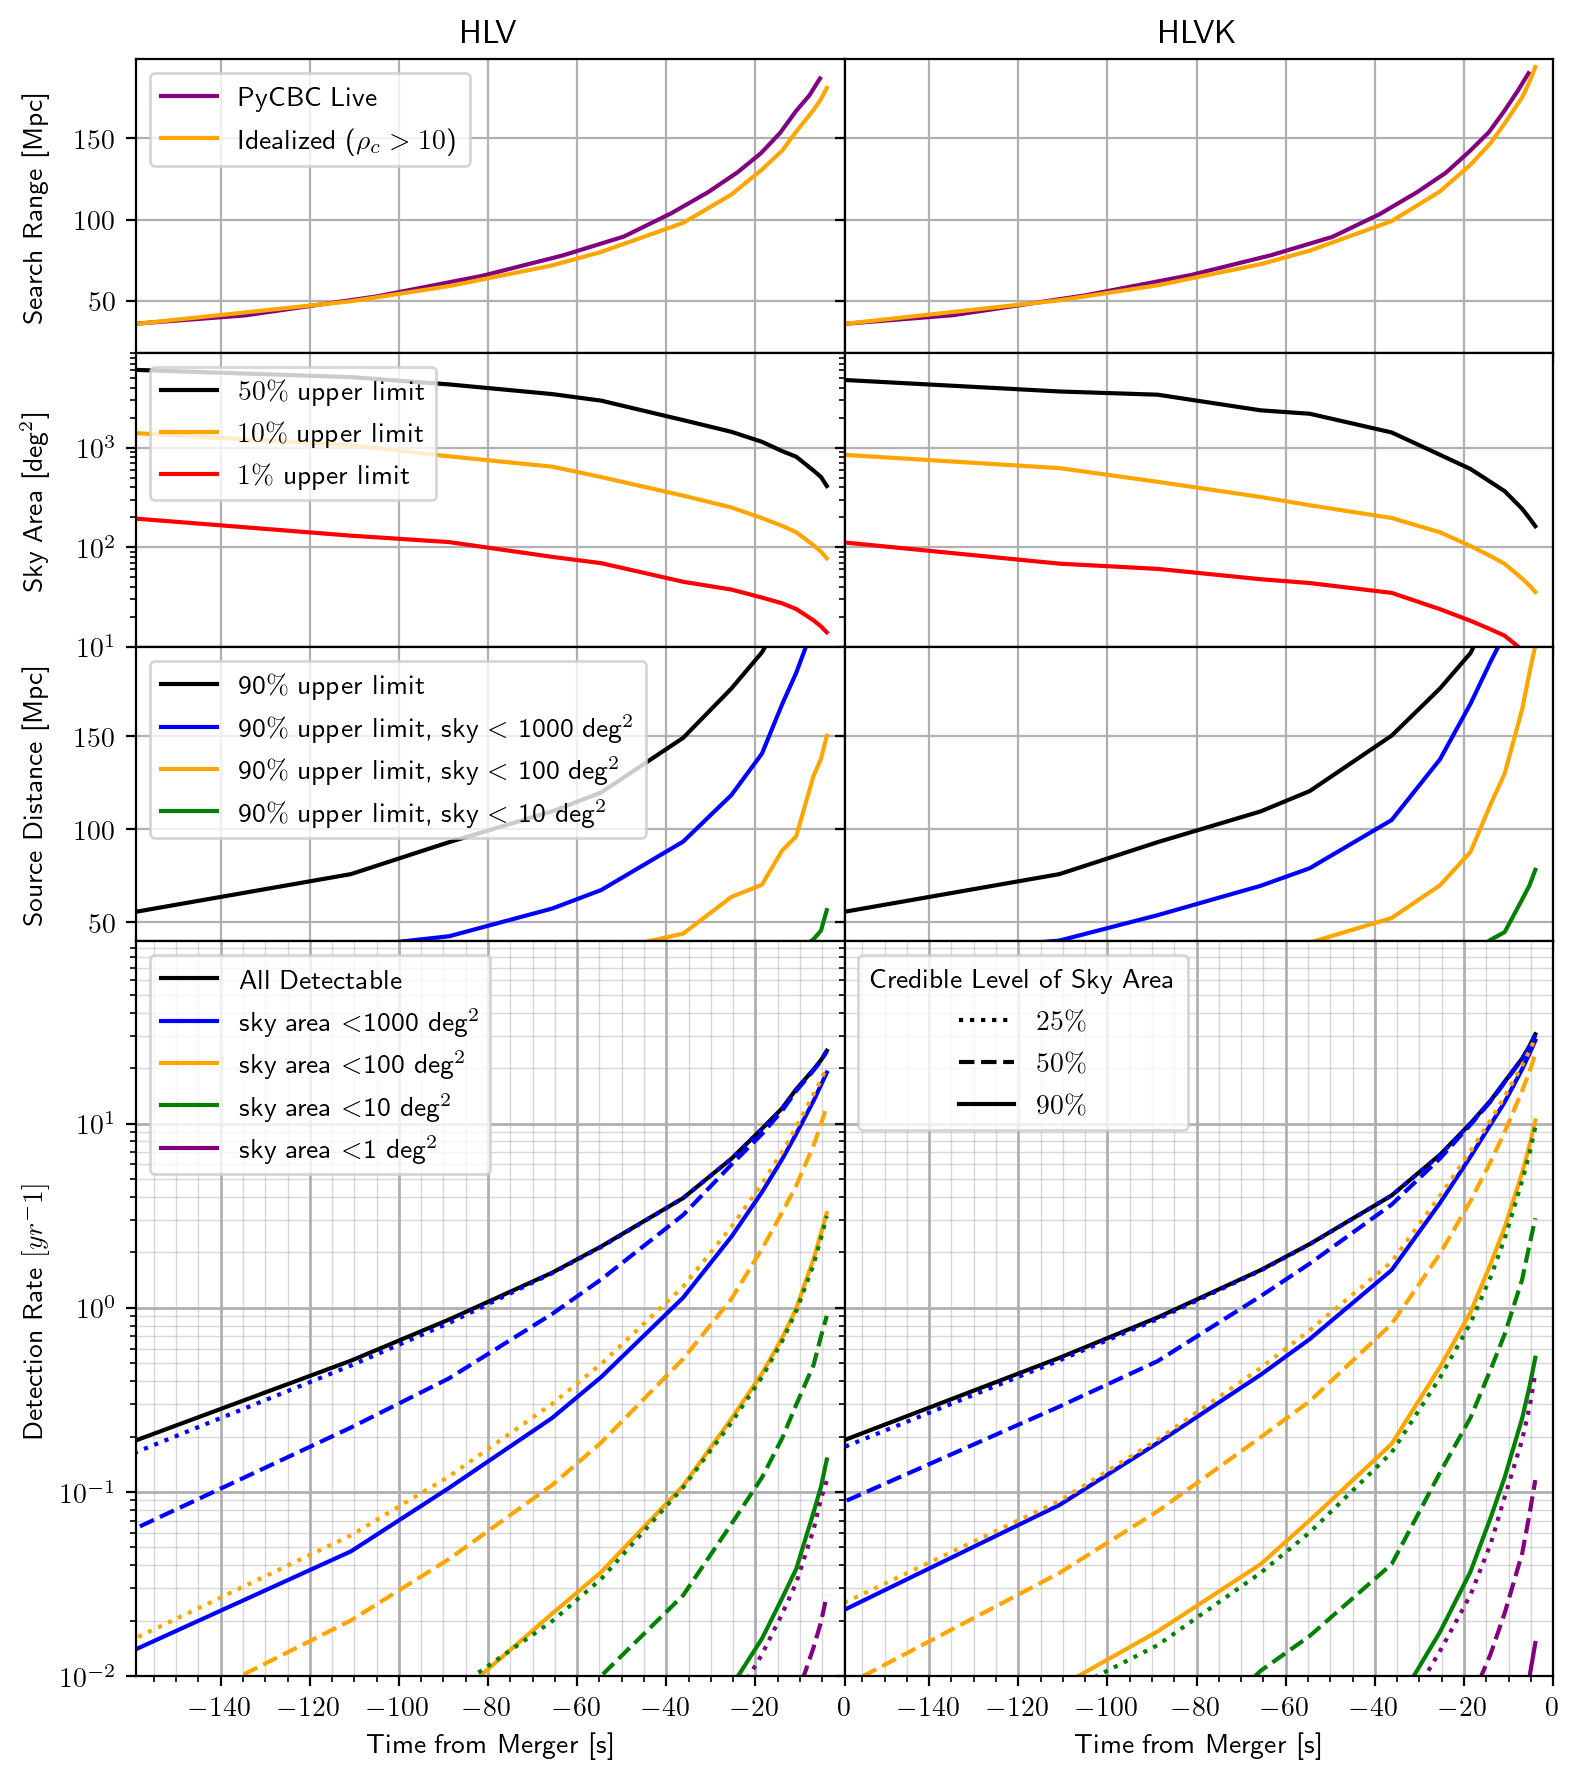

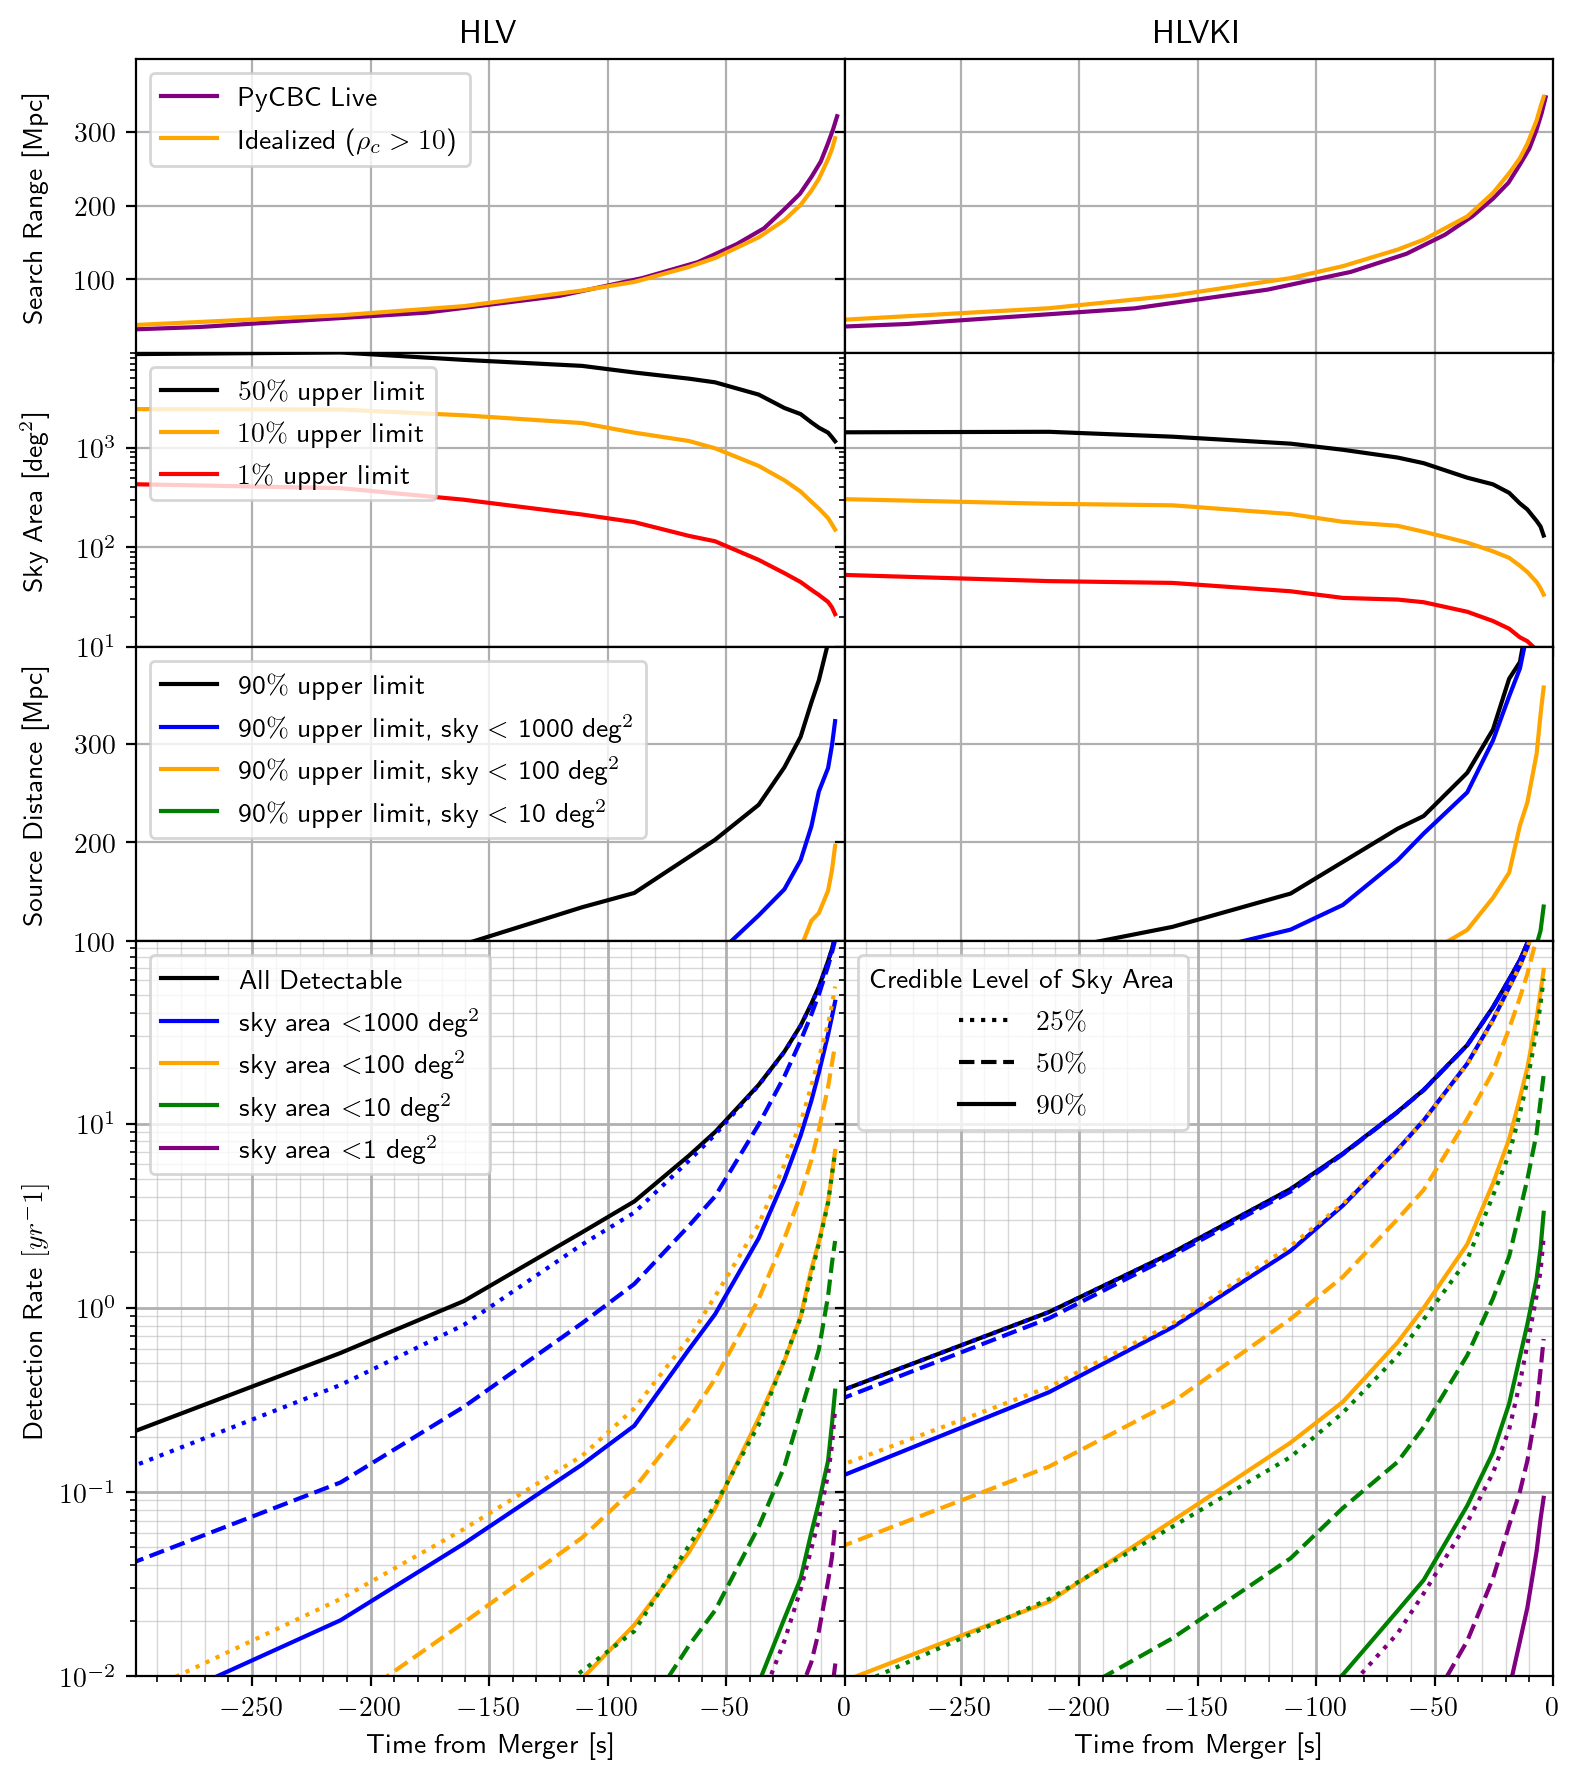

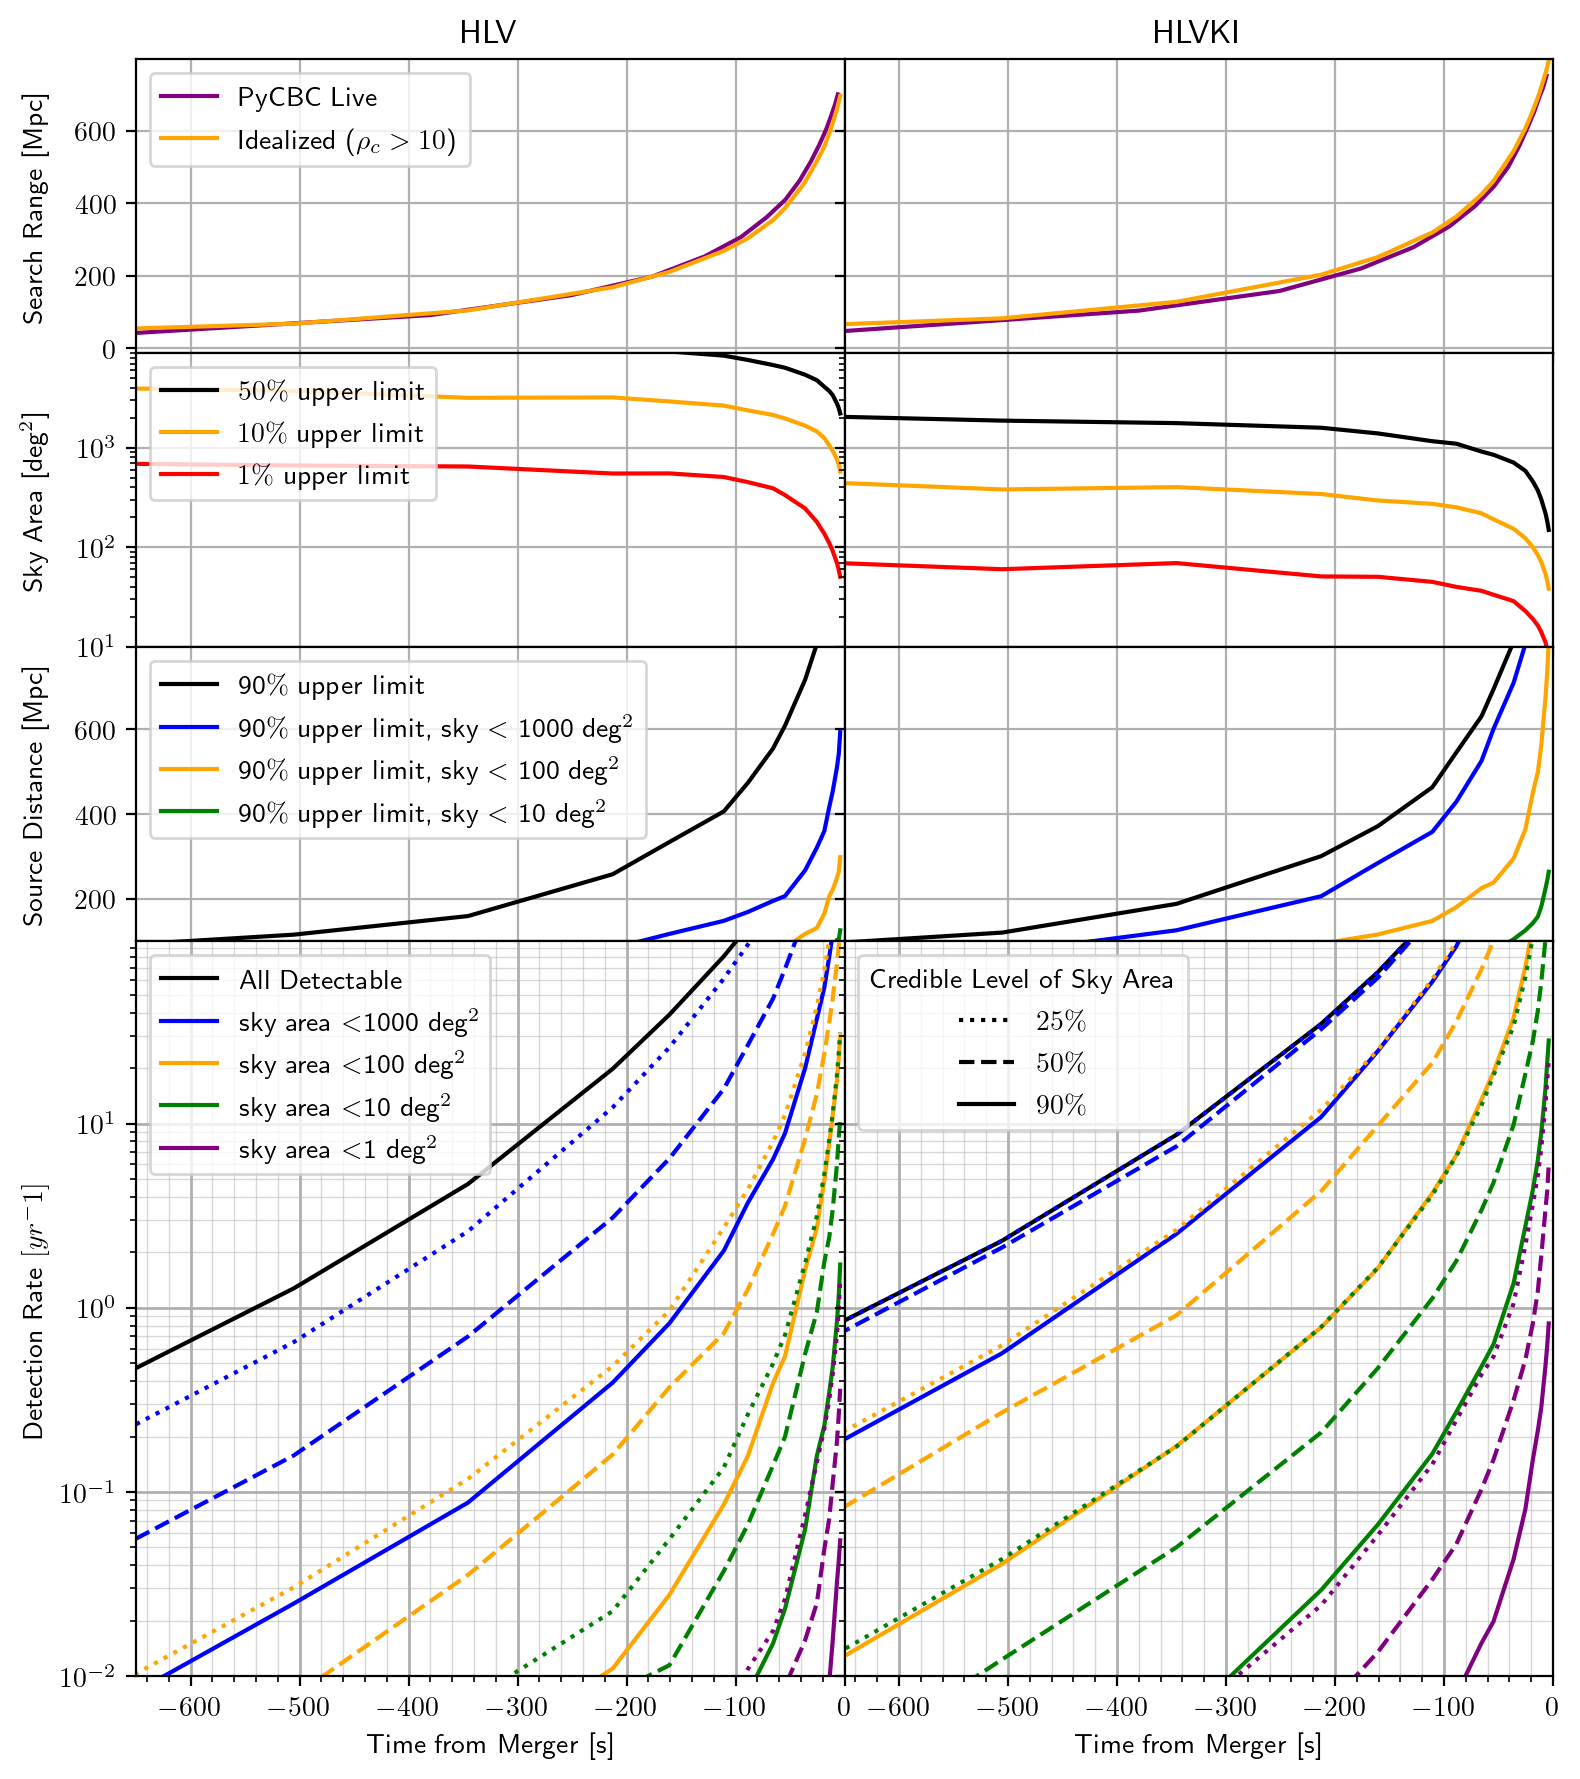

In [30]:
pylab.rc('text', usetex=True)

for era in combos:
    wide = len(combos[era])
    f, all_axes = pylab.subplots(4, wide, dpi=200, figsize=[8, 9], sharex=True, sharey='row',
                                 gridspec_kw={'height_ratios':[1, 1, 1, 2.5]}) 

    for i, abv in enumerate(combos[era]):
        axes = [all_axes[j, i] for j in range(4)]

        alpha = 1.0   

        
        pylab.sca(axes[0])
        pylab.title(abv.upper())
        timel, ds = search[era][abv]
        pylab.plot(timel, ds, label='PyCBC Live', color='purple', alpha=alpha)

        time = numpy.arange(timel.min(), -4, 1)
        time = sky[era][abv]['times']
        
        vol = volume[era][abv](time)
        dist = (vol / (4.0 / 3.0) / numpy.pi) ** (1.0 / 3.0)
        
        pylab.plot(time, dist, label='Idealized ($\\rho_c > 10$)', color='orange', alpha=alpha)
        pylab.grid()

        if i == 0:
            pylab.plot()
            pylab.legend(loc="upper left")
            pylab.ylabel('Search Range [Mpc]')  
            pylab.ylim(ymax={'design':199, 'aplus':399, 'voyager':799}[era])


        pylab.sca(axes[1])    
        v = sky[era][abv]['s50'](time)
        pylab.plot(time[v>0], v[v>0], color='black', label='$50\%$ upper limit')
        
        v = sky[era][abv]['s10'](time)
        pylab.plot(time[v>0], v[v>0], color='orange', label='$10\%$ upper limit')
        
        v = sky[era][abv]['s01'](time)
        pylab.plot(time[v>0], v[v>0], color='red', label='$1\%$ upper limit')
        pylab.grid() 
        
        if i == 0:
            pylab.legend(loc="upper left")
            pylab.ylabel('Sky Area [deg$^2$]')
            pylab.yscale('log')
            pylab.ylim(ymin=10, ymax=9000)



        pylab.sca(axes[2])
        pylab.plot(time, sky[era][abv]['d90'](time), label='90$\%$ upper limit', color='black', alpha=alpha)

        pylab.plot(time, sky[era][abv]['1000d90'](time), 
                   label='90$\%$ upper limit, sky $<$ 1000 deg$^2$', color='blue', alpha=alpha)
        pylab.plot(time, sky[era][abv]['100d90'](time), 
                   label='90$\%$ upper limit, sky $<$ 100 deg$^2$', color='orange', alpha=alpha)
        pylab.plot(time, sky[era][abv]['10d90'](time), 
                   label='90$\%$ upper limit, sky $<$ 10 deg$^2$', color='green', alpha=alpha)

        pylab.grid()
        if i == 0:    
            pylab.ylabel('Source Distance [Mpc]')
            pylab.legend(loc="upper left")
            pylab.ylim(ymin={'design':40, 'aplus':100, 'voyager':100}[era],
                       ymax={'design':198, 'aplus':398, 'voyager':795}[era])

        pylab.sca(axes[3])

        
        mrate = 1000
        v = volume[era][abv](time)
        drate = mrate * v / 1e9
        
        pylab.plot(time, drate, label='All Detectable' if not i else None, color='black', alpha=alpha,)
        
        for size, color in zip([1000, 100, 10, 1], ['blue', 'orange', 'green', 'purple']):
            for cred, line in zip([25, 50, 90], [':', '--', '-']):
                pylab.plot(time, drate * sky[era][abv]['{}a{}'.format(size, cred)](time),
                                   label='sky area $<${} deg$^2$'.format(size) if not i and cred==90 else None,
                                   color=color, linestyle=line)

        
        if i == 1:
            for cred, line in zip([25, 50, 90], [':', '--', '-']):
                pylab.plot([0, 0], [1, 1], label='${}\%$'.format(cred), color='black', linestyle=line)
            
            
            pylab.legend( title='Credible Level of Sky Area')
        
        pylab.grid(which='major', linewidth=1)
        pylab.grid(which='minor', linewidth=0.5, alpha=0.5)
        pylab.xlabel('Time from Merger [s]')

        if i == 0:
            pylab.ylabel('Detection Rate $[yr^-1]$')
            pylab.legend(loc="upper left")
            pylab.yscale('log')
            pylab.ylim(ymin=1e-2, ymax=98)
            pylab.xlim(xmin={'design':-159, 'aplus':-299, 'voyager':-650}[era],
                       xmax=0)
            pylab.gca().minorticks_on()

    f.align_labels()
    pylab.tight_layout()
    pylab.subplots_adjust(wspace=0, hspace=0)
    pylab.savefig(era + '.pdf')

In [31]:
def rate(era, config, time):
    mrate = 1000
    v = volume[era][config](time)
    drate = mrate * v / 1e9
    return drate * sky[era][config]['100a90'](time) 

print(rate('design', 'hlvk', -18))
print(rate('aplus', 'hlvki', -54))
print(rate('voyager', 'hlvki', -195))

def rate(era, config, time):
    mrate = 1000
    v = volume[era][config](time)
    drate = mrate * v / 1e9
    return drate * sky[era][config]['10a90'](time) 

print(rate('aplus', 'hlvki', -9))
print(rate('voyager', 'hlvki', -43))

1.006700812775981
1.0240306418933565
0.9850587380693473
1.0457956251230656
0.987917599910081


In [1]:
import h5py
fnames = ['design_hlv.hdf',
          'design_hlvk.hdf',
          'aplus_hlv.hdf',
          'aplus_hlvki.hdf',
          'voyager_hlv.hdf',
          'voyager_hlvki.hdf',
         ]

for fname in fnames:
    o = h5py.File(fname, 'w')
    f = h5py.File('../../results/%s' % fname, 'r')
    
    o['f_finals'] = f['f_finals'][:]
    o['ifar'] = f['f_finals'][:]
    
    
    for i, ff in enumerate(f['f_finals'][:]):
        ky = '%s/v' % (i)
        ke = '%s/ve' % (i)
        v = f[ky][:]
        e = f[ke][:]
        
        o[ky] = v
        o[ke] = e